In [ ]:
from tensorflow import keras
import tensorflow as tf
import tensorflow_addons  as tfa
from tensorflow.keras import backend as K
import pandas as pd
from pprint import pprint
import os 
import matplotlib.pyplot as plt
import numpy as np

os.chdir('/content/drive/My Drive/data/')

train_df = pd.read_csv('train/train.csv')

In [ ]:
train_df.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


In [ ]:
train_keys = train_df.keys()

train_mean_std = {
    key: {
        'mean': train_df[key].mean(),
        'std': train_df[key].std(),
    }for key in train_keys
}

train_min_max = {
    key: {
        'min': train_df[key].min(),
        'max': train_df[key].max(),
    }for key in train_keys
} 

pprint(train_mean_std)

norm_target = ['DHI', 'DNI', 'Hour', 'Minute', 'RH', 'T', 'TARGET', 'WS']

def df_normalization(df):
    df = df.drop(['Day'], axis=1)
    # df['Day'] = (df['Day'] % 365) / 365

    for key in norm_target:
        # df[key] = (df[key] - train_mean_std[key]['mean']) / train_mean_std[key]['std']
        df[key] = (df[key] - train_min_max[key]['min']) / (train_min_max[key]['max'] - train_min_max[key]['min'])


    return df

{'DHI': {'mean': 64.3441210045662, 'std': 103.8971253772147},
 'DNI': {'mean': 234.79237062404871, 'std': 349.68458288098145},
 'Day': {'mean': 547.0, 'std': 316.10214764047},
 'Hour': {'mean': 11.5, 'std': 6.922252403700084},
 'Minute': {'mean': 15.0, 'std': 15.00014269610012},
 'RH': {'mean': 56.79310159817326, 'std': 22.052875385665782},
 'T': {'mean': 9.279927701674277, 'std': 10.179741247478882},
 'TARGET': {'mean': 17.79062988523319, 'std': 25.759954586976853},
 'WS': {'mean': 2.4560331050228044, 'std': 1.426873937219954}}


In [ ]:
train_df = df_normalization(train_df)
train_df.head()

,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0.000000,0.0,0.0,0.0,0.125000,0.665404,0.12963,0.0
1,0.000000,1.0,0.0,0.0,0.125000,0.665188,0.12963,0.0
2,0.043478,0.0,0.0,0.0,0.133333,0.694622,0.12963,0.0
3,0.043478,1.0,0.0,0.0,0.133333,0.694297,0.12963,0.0
4,0.086957,0.0,0.0,0.0,0.133333,0.731631,0.12963,0.0


In [ ]:
train_x = []
train_y = []

In [ ]:
x_time_stamp = 48 * 7
y_time_stamp = 48 * 2

data = train_df.values.tolist()
target = train_df['TARGET'].tolist()

target_t = np.array([target for _ in range(9)]).T
for i in range(0, len(train_df) - x_time_stamp, 48):
    if i % 5000 == 0:
        print(f'{i} / {len(train_df)}')
    
    if (i + x_time_stamp + 1 + y_time_stamp) > len(target_t):
        break
    train_x.append(data[i: x_time_stamp + i])
    train_y.append(target_t[i + x_time_stamp: i + x_time_stamp + y_time_stamp])

0 / 52560
30000 / 52560


In [ ]:
train_x = np.array(train_x)
train_y = np.array(train_y)

In [ ]:
train_x.shape

(1086, 336, 8)

In [ ]:
train_y.shape

(1086, 96, 9)

In [ ]:
# def tilted_loss(q,y,f):
#     # e = (y-f)
#     # return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

#     return  (y-f) * q if y >= f else (f - y) * (1 - q)

In [ ]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.20, random_state=765)

In [ ]:
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    
    return K.mean(v)

# Legacy

In [ ]:
# model = keras.models.Sequential([
#     keras.layers.LSTM(256, dropout=.3, return_sequences=False, input_shape=(x_time_stamp, 8, )),
#     keras.layers.RepeatVector(96),
#     keras.layers.LSTM(128, dropout=.3, return_sequences=True),
#     keras.layers.TimeDistributed(keras.layers.Dense(64)),
#     keras.layers.TimeDistributed(keras.layers.Dropout(.3)),
#     keras.layers.TimeDistributed(keras.layers.Dense(9, activation="softplus"))
# ])

# model = keras.models.Sequential([
#     keras.layers.LSTM(128, dropout=.3, return_sequences=True, input_shape=(x_time_stamp, 8, )),
#     keras.layers.LSTM(64, dropout=.3, return_sequences=True),
#     keras.layers.Flatten(),
#     keras.layers.Dropout(.3),
#     keras.layers.Dense(y_time_stamp * 9 * 2, activation='relu'),
#     keras.layers.Dropout(.3),
#     keras.layers.Dense(y_time_stamp * 9, activation='softplus'),
#     tf.keras.layers.Reshape([y_time_stamp, 9])
# ])

# filter = 96
# model = keras.models.Sequential([
#     keras.layers.Conv1D(filter, 12, padding="same", activation="swish", input_shape=(x_time_stamp, 8, )),
#     keras.layers.MaxPooling1D(),
#     keras.layers.Dropout(.3),
#     keras.layers.Conv1D(filter, 12, padding="same", activation="swish"),
#     keras.layers.Flatten(),
#     keras.layers.Dropout(.3),
#     keras.layers.Dense(y_time_stamp * 9, activation='softplus'),
#     keras.layers.Reshape([y_time_stamp, 9])
# ])


# class Auto(keras.Model):
#     def __init__(self):
#         super(Auto, self).__init__()

#         self.encoder = keras.Sequential([
#             keras.layers.Input(shape=(x_time_stamp, 8, 1)),
#             keras.layers.Conv1D(96, 12, padding="same", activation="swish"),
#             keras.layers.Conv1D(48, 12, padding="same", activation="swish"),
#         ])

#         self.decoder = keras.Sequential([
#             keras.layers.Conv1DTranspose(48, 12, padding="same", activation="swish"),
#             keras.layers.Conv1DTranspose(96, 12, padding="same", activation="swish"),
#             keras.layers.Conv1D(1, 12, padding="same", activation="softplus"),
#         ])

#     def call(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

# model = Auto()

model = keras.models.Sequential([
    keras.layers.Conv1D(96, 24, padding="same", activation="relu", input_shape=(x_time_stamp, 8, ), strides=4),
    keras.layers.Dropout(.3),
    keras.layers.Conv1D(192, 24, padding="same", activation="relu", strides=7),
    keras.layers.Dropout(.3),
    keras.layers.Conv1DTranspose(192, 24, padding="same", activation="relu", strides=2),
    keras.layers.Dropout(.3),
    keras.layers.Conv1DTranspose(96, 24, padding="same", activation="relu", strides=4),
    keras.layers.Dropout(.3),
    keras.layers.Conv1D(9, 12, padding="same", activation="softmax"),
])

model.compile(loss=qloss, optimizer=keras.optimizers.Adam(0.0001))
model.summary()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_135 (Conv1D)          (None, 84, 96)            18528     
_________________________________________________________________
dropout_20 (Dropout)         (None, 84, 96)            0         
_________________________________________________________________
conv1d_136 (Conv1D)          (None, 12, 192)           442560    
_________________________________________________________________
dropout_21 (Dropout)         (None, 12, 192)           0         
_________________________________________________________________
conv1d_transpose_78 (Conv1DT (None, 24, 192)           884928    
_________________________________________________________________
dropout_22 (Dropout)         (None, 24, 192)           0         
_________________________________________________________________
conv1d_transpose_79 (Conv1DT (None, 96, 96)          

In [ ]:
filter = 16

def multi_kernel(filter_size, input_layer):
    kernel_size = [6, 24, 48]
    conv_blocks = []

    for ks in kernel_size:
        conv = keras.layers.Conv1D(filter_size, ks, padding="valid", activation="relu")(input_layer)
        # max_pool = keras.layers.GlobalMaxPooling1D()(conv)
        fl = keras.layers.Flatten()(conv)
        conv_blocks.append(fl)

    return conv_blocks

x_input = keras.Input((x_time_stamp, 8, ))
convs = multi_kernel(filter, x_input)

concatenate = keras.layers.Concatenate()(convs)
do2 = keras.layers.Dropout(.5)(concatenate)
d1 = keras.layers.Dense(y_time_stamp * 9 * 4, activation='relu')(do2)
do3 = keras.layers.Dropout(.3)(d1)
output = keras.layers.Dense(y_time_stamp * 9, activation='sigmoid')(do3)
reshape = keras.layers.Reshape([y_time_stamp, 9])(output)

model = keras.models.Model(x_input, reshape)

model.compile(loss=qloss, optimizer=keras.optimizers.Adam(0.0001))
model.summary()
# keras.utils.plot_model(model)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 336, 8)]     0                                            
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 331, 16)      784         input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 313, 16)      3088        input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 289, 16)      6160        input_6[0][0]                    
____________________________________________________________________________________________

# 2020 - 12 - 26

In [ ]:
# filter = 16 (두번째 서브미션) 1.9434064724	
# kernel_size = [6, 24, 48]
# Epoch 306/500
# 1/1 [==============================] - 0s 141ms/step - loss: 0.0215 - val_loss: 0.0212

filter = 16
kernel_size = [6, 24, 48]

def multi_kernel(filter_size, input_layer):
    conv_blocks = []

    for ks in kernel_size:
        conv = keras.layers.Conv1D(filter_size, ks, padding="valid", activation="relu")(input_layer)
        # max_pool = keras.layers.GlobalMaxPooling1D()(conv)
        fl = keras.layers.Flatten()(conv)
        conv_blocks.append(fl)

    return conv_blocks

x_input = keras.Input((x_time_stamp, 8, ))
convs = multi_kernel(filter, x_input)

concatenate = keras.layers.Concatenate()(convs)
do2 = keras.layers.Dropout(.5)(concatenate)
d1 = keras.layers.Dense(y_time_stamp * 9 * 4, activation='relu')(do2)
do3 = keras.layers.Dropout(.3)(d1)
output = keras.layers.Dense(y_time_stamp * 9, activation='sigmoid')(do3)
reshape = keras.layers.Reshape([y_time_stamp, 9])(output)

model = keras.models.Model(x_input, reshape)

model.compile(loss=qloss, optimizer=keras.optimizers.Adam(0.0001))
# model.compile(loss=qloss, optimizer=keras.optimizers.(0.0001))
model.summary()
# keras.utils.plot_model(model)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 336, 8)]     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 331, 16)      784         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 313, 16)      3088        input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 289, 16)      6160        input_4[0][0]                    
____________________________________________________________________________________________

In [ ]:
# filter = 16 (세번째 서브미션) 1.9635535533
# kernel_size = [6, 24, 48]
# Epoch 306/500
# 1/1 [==============================] - 0s 141ms/step - loss: 0.0215 - val_loss: 0.0212

filter = 16
kernel_size = [6, 24, 48]

def multi_kernel(filter_size, input_layer):
    conv_blocks = []

    for ks in kernel_size:
        conv1 = keras.layers.Conv1D(filter_size, ks, padding="valid", activation="relu")(input_layer)
        max_pool = keras.layers.MaxPooling1D()(conv1)
        conv2 = keras.layers.Conv1D(filter_size, ks, padding="valid", activation="relu")(max_pool)
        fl = keras.layers.Flatten()(conv2)
        conv_blocks.append(fl)

    return conv_blocks

x_input = keras.Input((x_time_stamp, 8, ))
convs = multi_kernel(filter, x_input)

concatenate = keras.layers.Concatenate()(convs)
do2 = keras.layers.Dropout(.5)(concatenate)
d1 = keras.layers.Dense(y_time_stamp * 9 * 4, activation='relu')(do2)
do3 = keras.layers.Dropout(.3)(d1)
output = keras.layers.Dense(y_time_stamp * 9, activation='sigmoid')(do3)
reshape = keras.layers.Reshape([y_time_stamp, 9])(output)

model = keras.models.Model(x_input, reshape)

model.compile(loss=qloss, optimizer=keras.optimizers.Adam(0.0001))
model.summary()
# keras.utils.plot_model(model)

Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 336, 8)]     0                                            
__________________________________________________________________________________________________
conv1d_126 (Conv1D)             (None, 331, 16)      784         input_34[0][0]                   
__________________________________________________________________________________________________
conv1d_128 (Conv1D)             (None, 313, 16)      3088        input_34[0][0]                   
__________________________________________________________________________________________________
conv1d_130 (Conv1D)             (None, 289, 16)      6160        input_34[0][0]                   
___________________________________________________________________________________________

# 2020 - 12 - 27

In [ ]:
# (첫번째 서브미션) 2.1797385838	
# def qloss(y_true, y_pred):
#     # Pinball loss for multiple quantiles
#     qs = [0.6, 0.17, 0.28, 0.39, 0.5, 0.61, 0.72, 0.83, 0.94]
#     q = tf.constant(np.array([qs]), dtype=tf.float32)
#     e = y_true - y_pred
#     v = tf.maximum(q*e, (q-1)*e)
    
#     return K.mean(v)

In [ ]:
# filter = 16
# kernel_size = [6, 24, 48]

# def multi_kernel(filter_size, input_layer):
#     conv_blocks = []

#     for ks in kernel_size:
#         conv = keras.layers.Conv1D(filter_size, ks, padding="valid", activation="relu")(input_layer)
#         # max_pool = keras.layers.GlobalMaxPooling1D()(conv)
#         fl = keras.layers.Flatten()(conv)
#         conv_blocks.append(fl)

#     return conv_blocks

# x_input = keras.Input((x_time_stamp, 8, ))
# convs = multi_kernel(filter, x_input)

# concatenate = keras.layers.Concatenate()(convs)
# do2 = keras.layers.Dropout(.5)(concatenate)
# d1 = keras.layers.Dense(y_time_stamp * 9 * 4, activation='relu')(do2)
# do3 = keras.layers.Dropout(.3)(d1)
# output = keras.layers.Dense(y_time_stamp * 9, activation='sigmoid')(do3)
# reshape = keras.layers.Reshape([y_time_stamp, 9])(output)

# model = keras.models.Model(x_input, reshape)

# model.compile(loss=qloss, optimizer=keras.optimizers.Adam(0.0001))
# model.summary()
# # keras.utils.plot_model(model)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 336, 8)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 331, 16)      784         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 313, 16)      3088        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 289, 16)      6160        input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
# (두번째 서브미션) 1.9573356779	
# filter = 48
filter = 48
model = keras.models.Sequential([
    keras.layers.Conv1D(filter, 48, padding="same", activation="relu", input_shape=(x_time_stamp, 8, )),
    keras.layers.MaxPooling1D(),
    keras.layers.Dropout(.3),
    keras.layers.Conv1D(filter, 48, padding="same", activation="relu"),
    keras.layers.Flatten(),
    keras.layers.Dropout(.3),  #s3 del
    keras.layers.Dense(y_time_stamp * 9, activation='sigmoid'),
    keras.layers.Reshape([y_time_stamp, 9])
])

model.compile(loss=qloss, optimizer=keras.optimizers.Adam())
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, 336, 48)           18480     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 168, 48)           0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 168, 48)           0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 168, 48)           110640    
_________________________________________________________________
flatten_15 (Flatten)         (None, 8064)              0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 8064)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 864)             

In [ ]:
# filter = 16 (두번째 서브미션) 1.9434064724	
# kernel_size = [6, 24, 48]
# Epoch 306/500
# 1/1 [==============================] - 0s 141ms/step - loss: 0.0215 - val_loss: 0.0212

filter = 24
# kernel_size = [6, 24, 48]

def multi_kernel(filter_size, input_layer):
    # conv_blocks = []

    conv_1 = keras.layers.Conv1D(filter_size, kernel_size=1, strides=1, padding="same", activation="relu")(input_layer)

    conv_2 = keras.layers.Conv1D(filter_size, kernel_size=3, strides=1, padding="same", activation="relu")(input_layer)
    
    conv_3 = keras.layers.Conv1D(filter_size, kernel_size=1, strides=1, padding="same", activation="relu")(input_layer)
    conv_3 = keras.layers.Conv1D(filter_size, kernel_size=5, strides=1, padding="same", activation="relu")(conv_3)
    
    conv_4 = keras.layers.Conv1D(filter_size, kernel_size=1, strides=1, padding="same", activation="relu")(input_layer)
    conv_4 = keras.layers.Conv1D(filter_size, kernel_size=3, strides=1, padding="same", activation="relu")(conv_3)

    outputs = keras.layers.Concatenate()([conv_1, conv_2, conv_3, conv_4])
    # outputs = keras.layers.Flatten()(outputs)
    # for ks in kernel_size:
    #     conv = keras.layers.Conv1D(filter_size, ks, padding="valid", activation="relu")(input_layer)
    #     # max_pool = keras.layers.GlobalMaxPooling1D()(conv)
    #     fl = keras.layers.Flatten()(conv)
    #     conv_blocks.append(fl)

    return outputs

x_input = keras.Input((x_time_stamp, 8, ))
convs = multi_kernel(filter, x_input)
convs = multi_kernel(filter, convs)
fl = keras.layers.GlobalAvgPool1D()(convs)

# concatenate = keras.layers.Concatenate()(convs)
do2 = keras.layers.Dropout(.3)(fl)
d1 = keras.layers.Dense(y_time_stamp * 9 * 4, activation='relu')(do2)
do3 = keras.layers.Dropout(.3)(d1)
output = keras.layers.Dense(y_time_stamp * 9, activation='sigmoid')(do3)
reshape = keras.layers.Reshape([y_time_stamp, 9])(output)

model = keras.models.Model(x_input, reshape)

model.compile(loss=qloss, optimizer=keras.optimizers.RMSprop(.001))
model.summary()
# keras.utils.plot_model(model)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 336, 8)]     0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 336, 24)      216         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 336, 24)      2904        conv1d_2[0][0]                   
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 336, 24)      216         input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
convs.shape

TensorShape([None, 336, 48])

#2020 - 12 - 31

In [ ]:
 filter = 16
kernel_size = [6, 24, 48]

def multi_kernel(filter_size, input_layer):
    conv_blocks = []

    for ks in kernel_size:
        conv = keras.layers.Conv1D(filter_size, ks, padding="valid", activation="relu")(input_layer)
        # max_pool = keras.layers.GlobalMaxPooling1D()(conv)
        fl = keras.layers.Flatten()(conv)
        conv_blocks.append(fl)

    return conv_blocks

x_input = keras.Input((x_time_stamp, 8, ))
convs = multi_kernel(filter, x_input)

concatenate = keras.layers.Concatenate()(convs)
do2 = keras.layers.Dropout(.5)(concatenate)
d1 = keras.layers.Dense(y_time_stamp * 9 * 4, activation='relu')(do2)
do3 = keras.layers.Dropout(.3)(d1)
output = keras.layers.Dense(y_time_stamp * 9, activation='sigmoid')(do3)
reshape = keras.layers.Reshape([y_time_stamp, 9])(output)

model = keras.models.Model(x_input, reshape)

model.compile(loss=qloss, optimizer=keras.optimizers.Adam(0.0001))
# model.compile(loss=qloss, optimizer=keras.optimizers.(0.0001))
model.summary()
# keras.utils.plot_model(model)

# Train

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# for i, model in enumerate(model_list):
#     print(f'cur quantile = {quantiles[i]}')
hist = model.fit(train_x, train_y, validation_data=(val_x, val_y), shuffle=True, epochs=500, batch_size=1024, callbacks=[es])


Epoch 1/500
1/1 [==============================] - 1s 760ms/step - loss: 0.1914 - val_loss: 0.0524
Epoch 2/500
1/1 [==============================] - 0s 162ms/step - loss: 0.0544 - val_loss: 0.0460
Epoch 3/500
1/1 [==============================] - 0s 137ms/step - loss: 0.0480 - val_loss: 0.0435
Epoch 4/500
1/1 [==============================] - 0s 130ms/step - loss: 0.0475 - val_loss: 0.0425
Epoch 5/500
1/1 [==============================] - 0s 126ms/step - loss: 0.0461 - val_loss: 0.0413
Epoch 6/500
1/1 [==============================] - 0s 127ms/step - loss: 0.0444 - val_loss: 0.0395
Epoch 7/500
1/1 [==============================] - 0s 120ms/step - loss: 0.0427 - val_loss: 0.0377
Epoch 8/500
1/1 [==============================] - 0s 129ms/step - loss: 0.0409 - val_loss: 0.0361
Epoch 9/500
1/1 [==============================] - 0s 128ms/step - loss: 0.0392 - val_loss: 0.0346
Epoch 10/500
1/1 [==============================] - 0s 128ms/step - loss: 0.0377 - val_loss: 0.0334
Epoch 11/

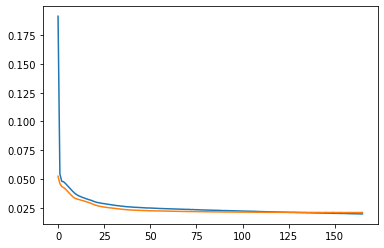

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [ ]:
tar = 239
res = model.predict([val_x[tar].tolist()])

IndexError: ignored

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(range(x_time_stamp), val_y[tar].T[0], label='original')

plt.plot(range(x_time_stamp, x_time_stamp + y_time_stamp), res[0].T[0], label='0.1')
plt.plot(range(x_time_stamp, x_time_stamp + y_time_stamp), res[0].T[4], label='0.5')
plt.plot(range(x_time_stamp, x_time_stamp + y_time_stamp), res[0].T[8], label='0.9')
plt.legend()
plt.grid(True)
plt.show()

NameError: ignored

<Figure size 1440x360 with 0 Axes>

In [ ]:
test_target = [i for i in range(81)]

0


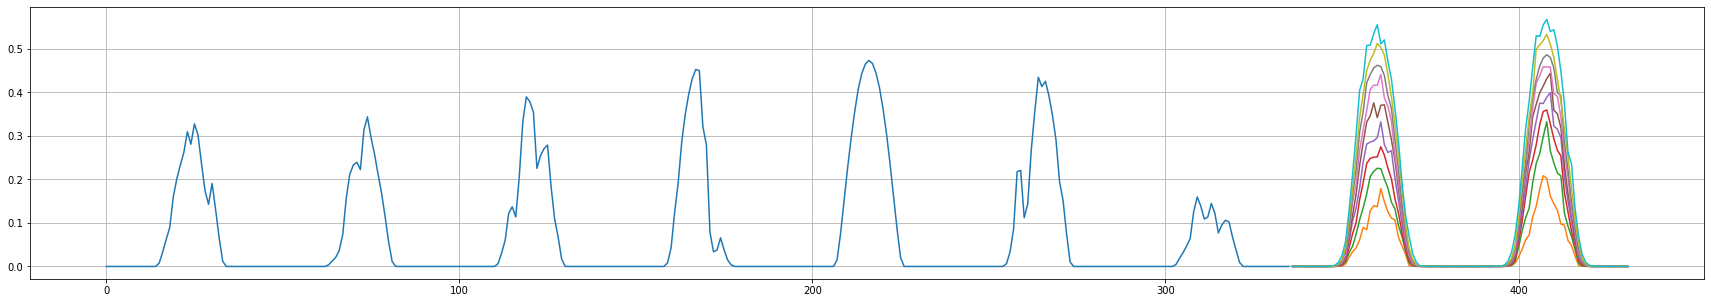

5


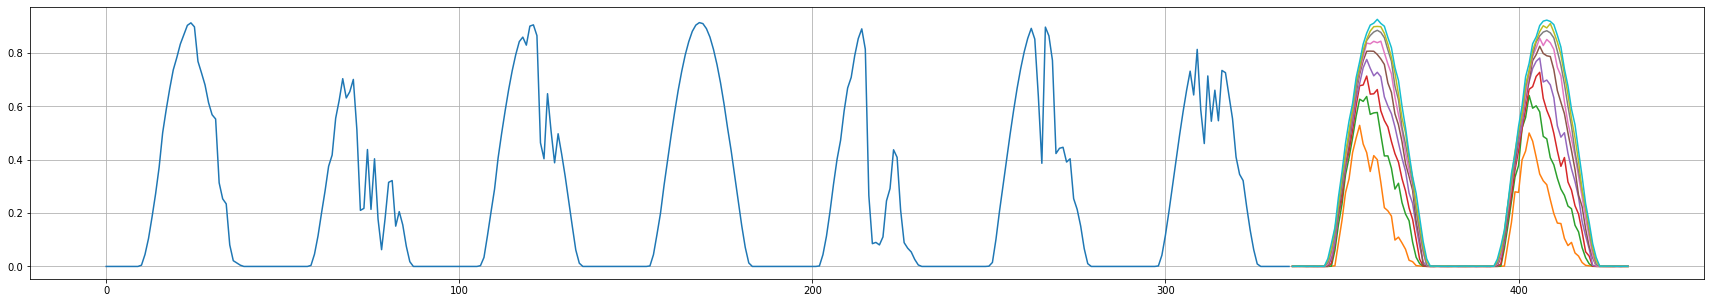

10


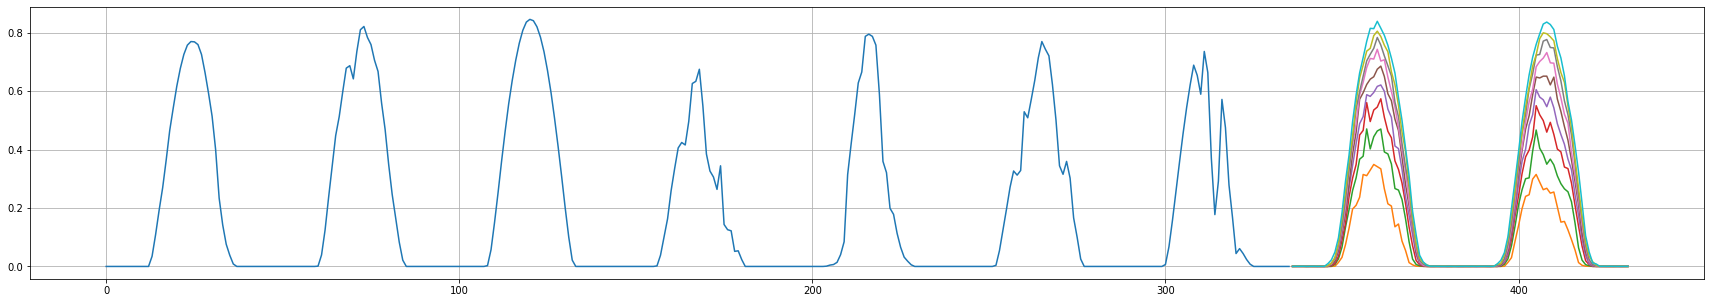

15


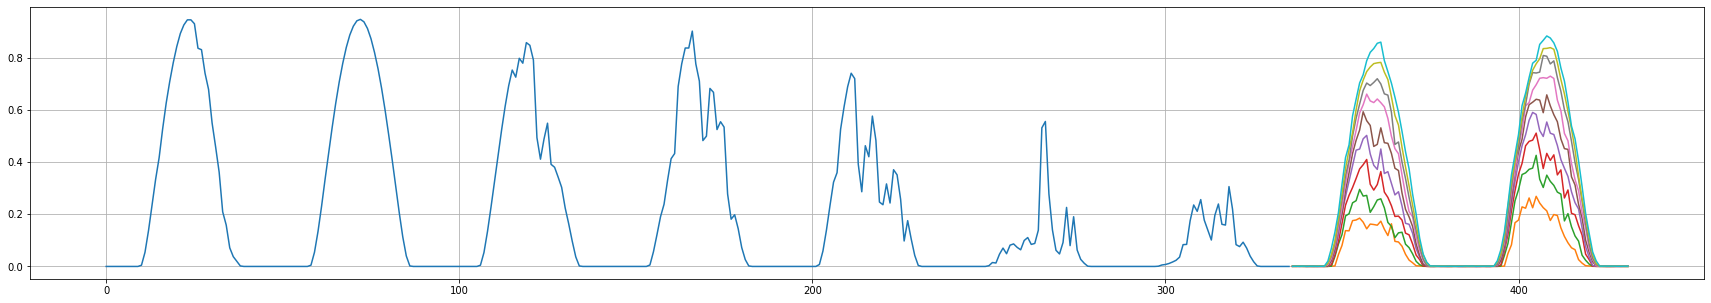

20


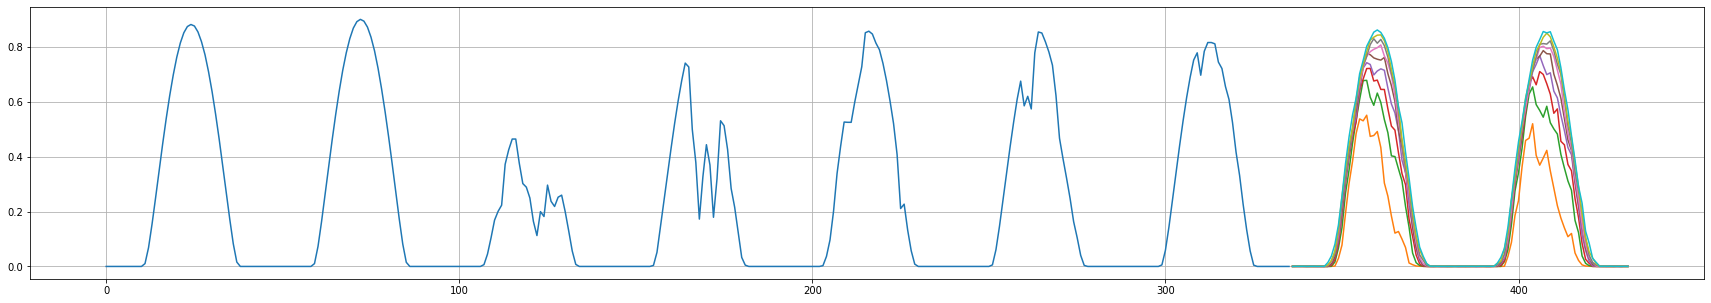

25


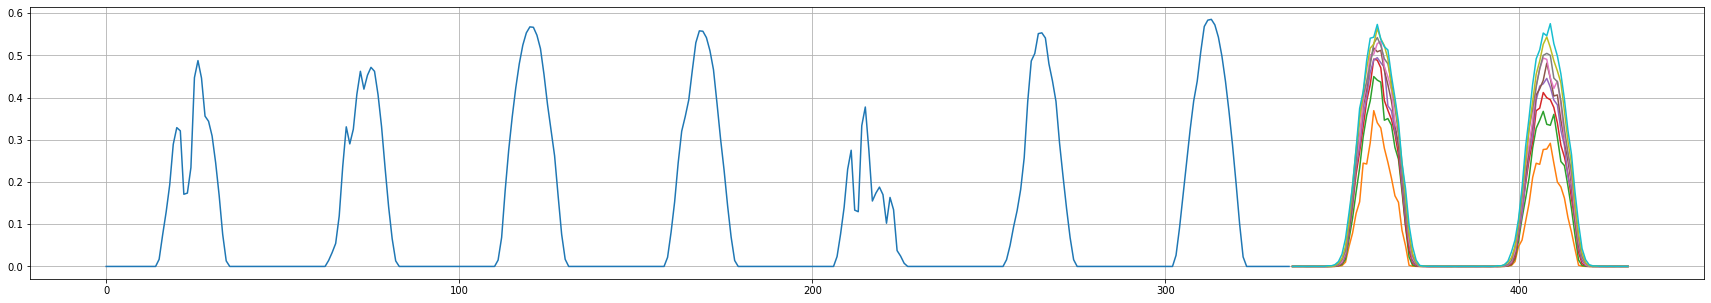

30


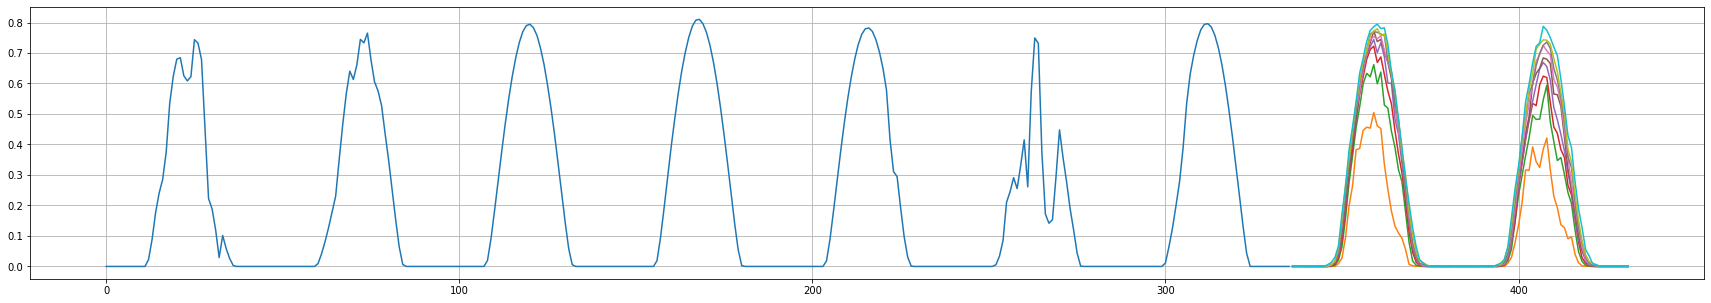

35


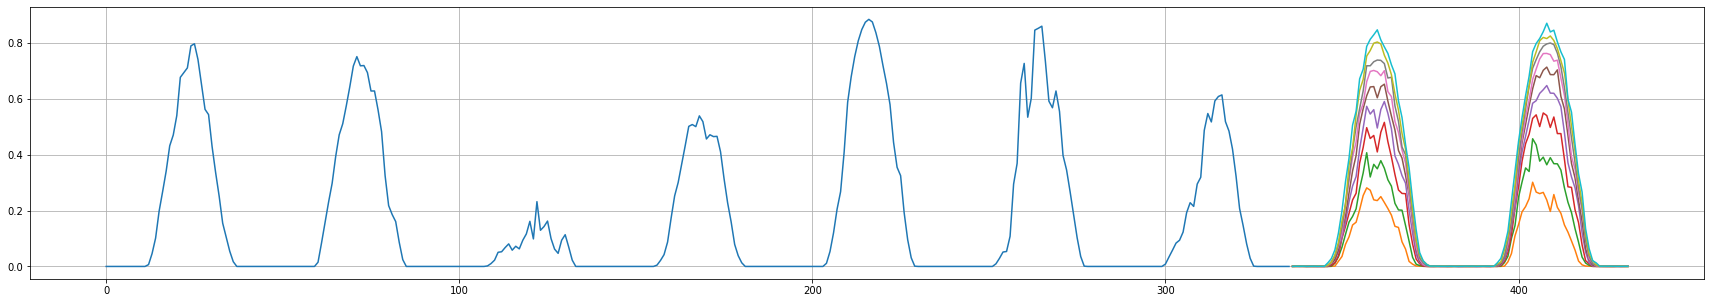

40


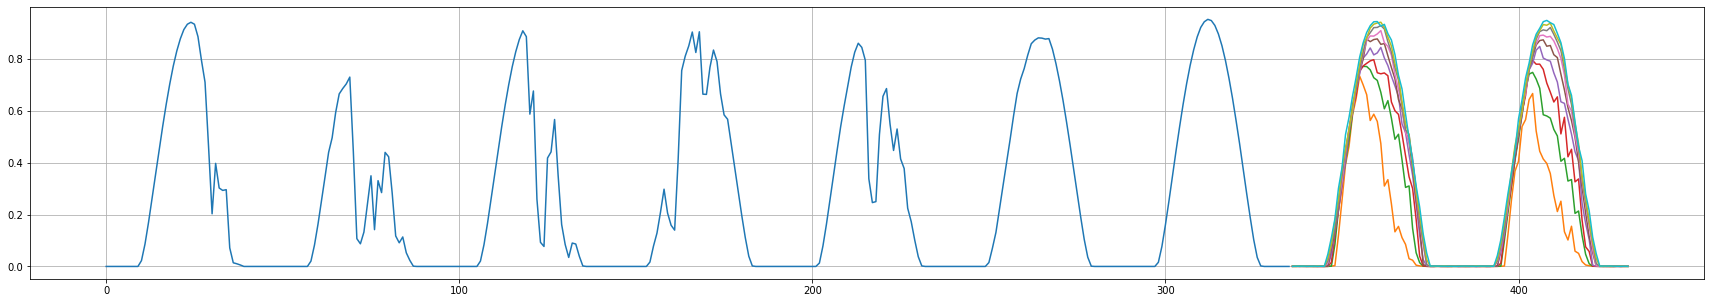

45


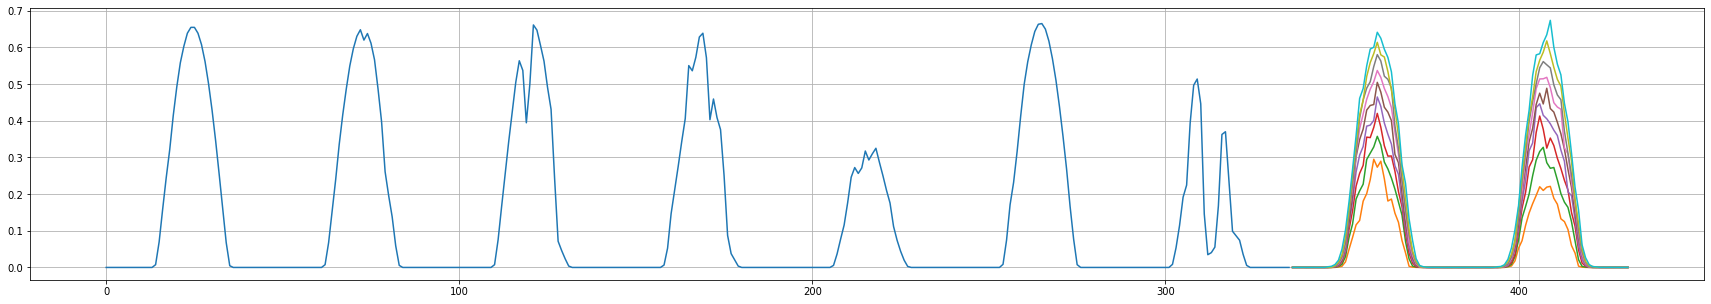

50


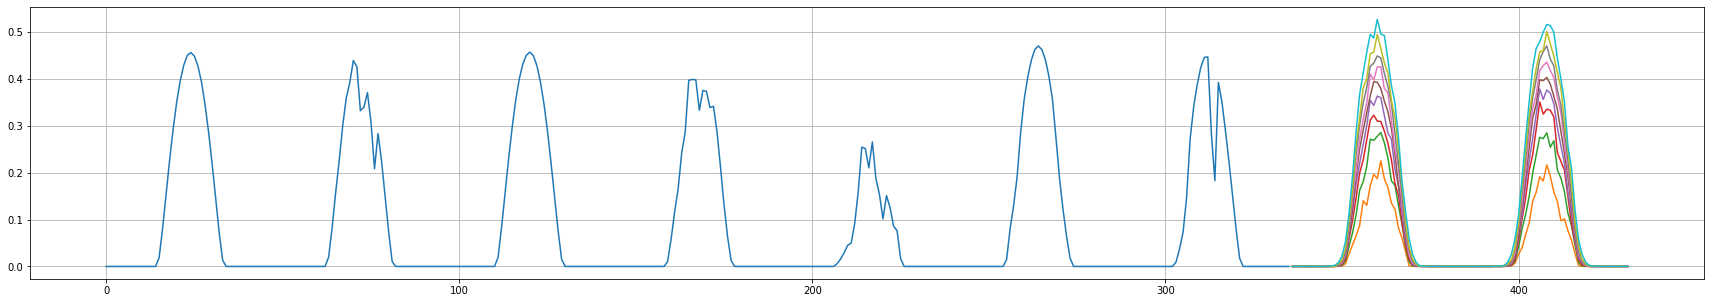

55


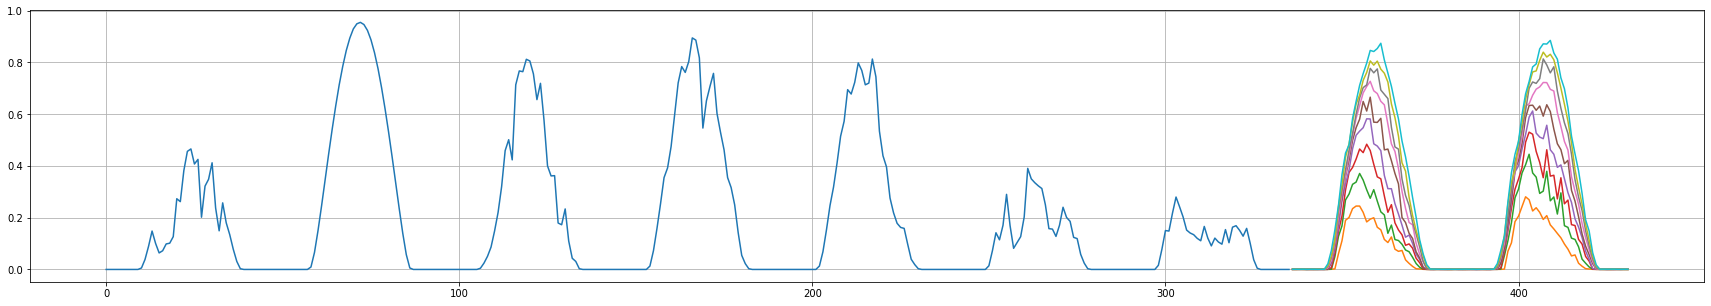

60


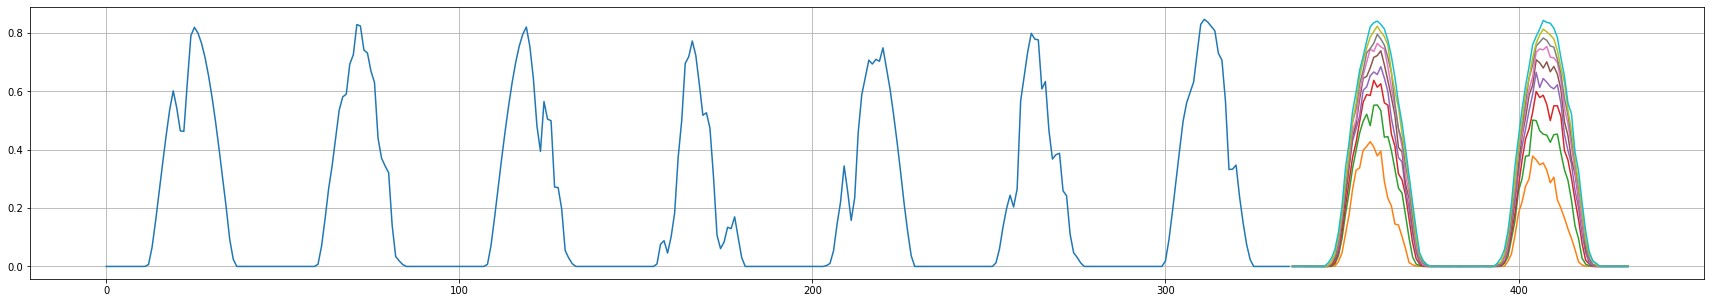

65


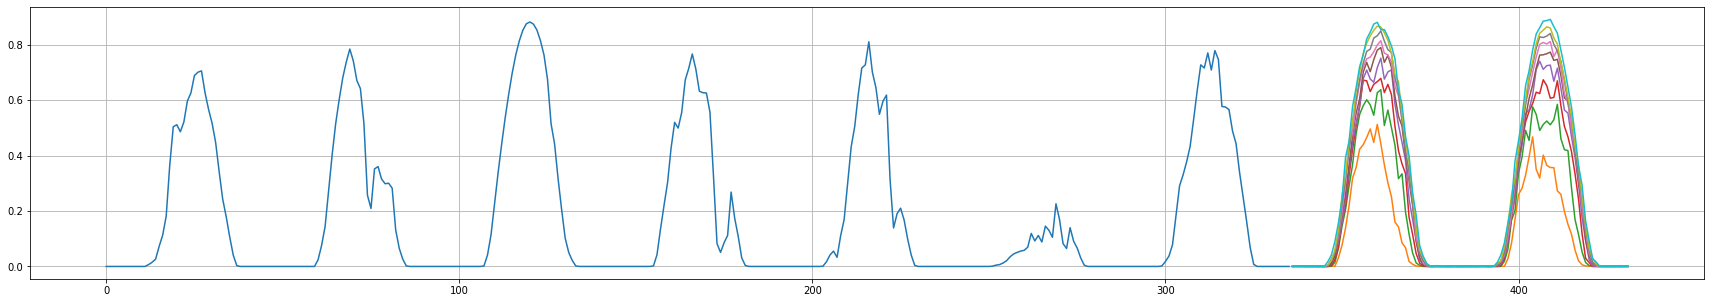

70


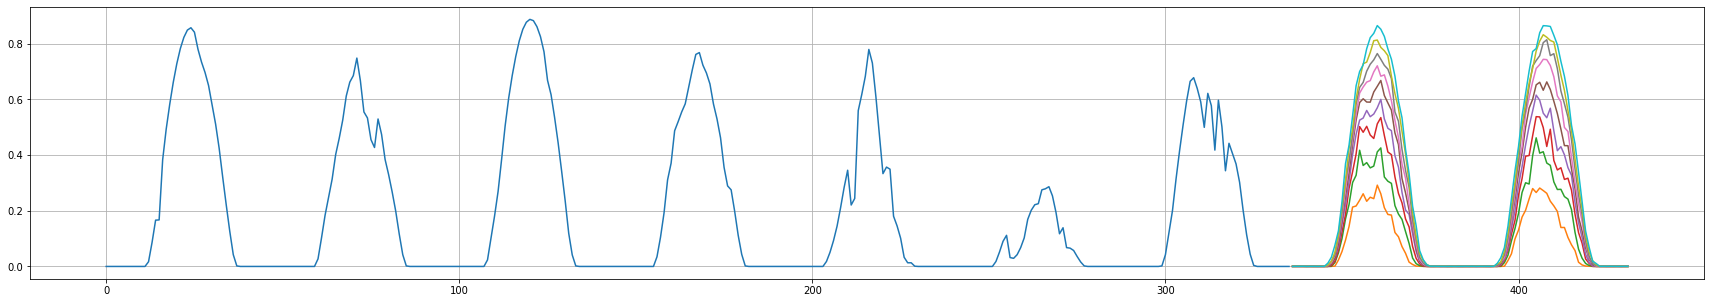

75


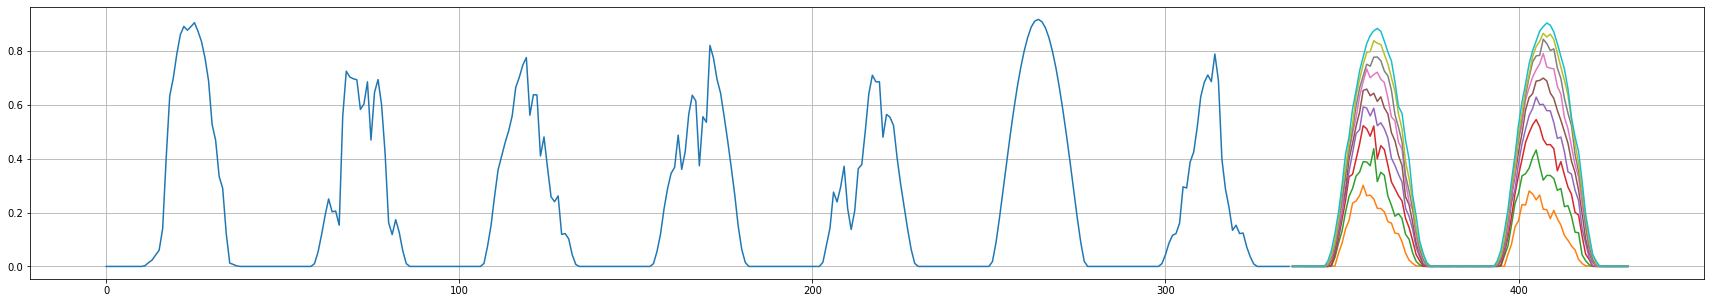

80


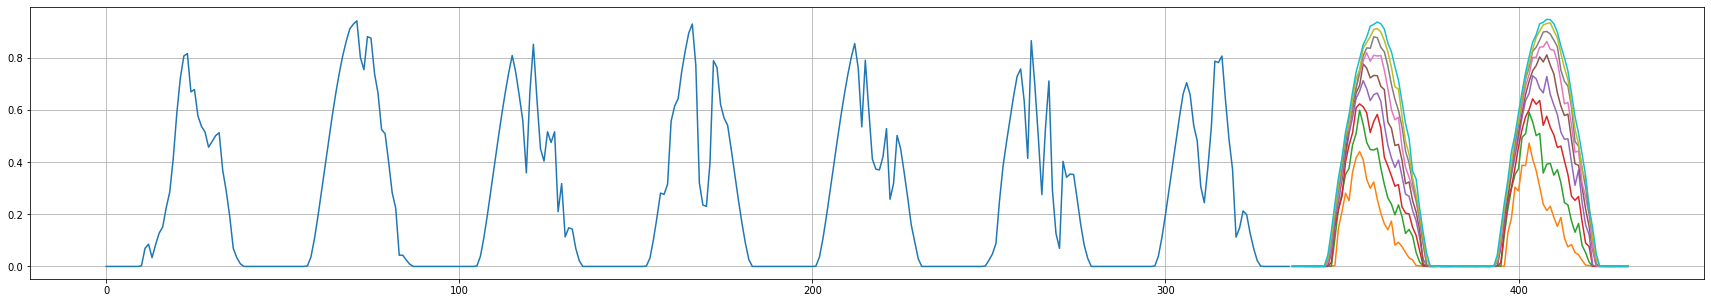

In [ ]:
result_q = [[] for _ in range(9)]

for i in test_target:
    test_df = pd.read_csv(f'test/{i}.csv')
    test_df = df_normalization(test_df)

    res = model.predict([test_df.values.tolist()])

    for j in range(9):
        result_q[j] = result_q[j] + res[0].T[j].tolist()


    if i % 5 == 0:
        print(i)
        plt.figure(figsize=(30, 5))
        plt.plot(range(x_time_stamp), test_df['TARGET'])
        plt.plot(range(x_time_stamp, x_time_stamp + y_time_stamp), res[0])

        plt.grid(True)
        plt.show()

81

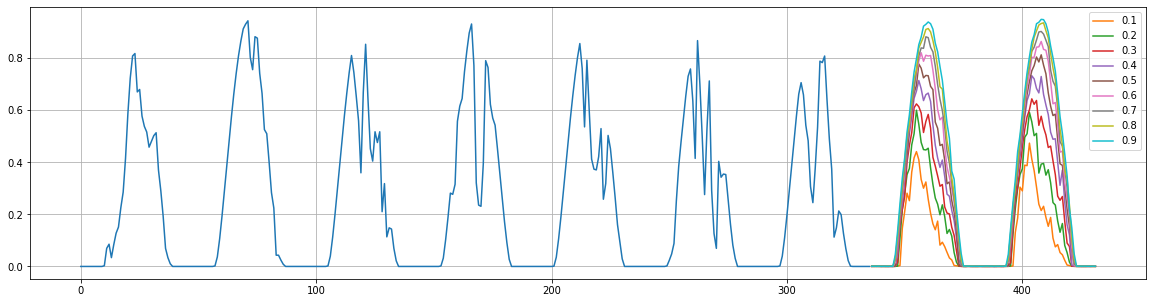

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(range(x_time_stamp), test_df['TARGET'])

stamp = 0
for i in range(9):
    plt.plot(range(x_time_stamp, x_time_stamp + y_time_stamp), np.array(result_q[i][-y_time_stamp: ]), label=f'0.{i + 1}')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
result = np.array(result_q)
# result = result * train_mean_std['TARGET']['std'] + train_mean_std['TARGET']['mean']

result = result * (train_min_max['TARGET']['max'] - train_min_max['TARGET']['min']) + train_min_max['TARGET']['min']

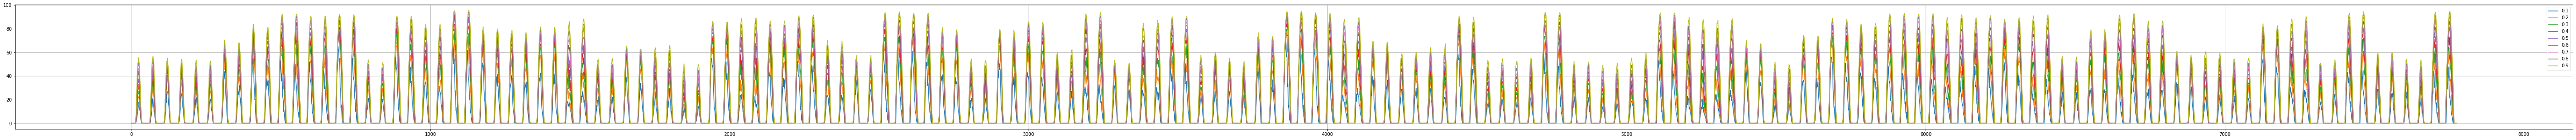

In [ ]:
plt.figure(figsize=(100, 5))
for i in range(9):
    plt.plot(result[i], label=f'0.{i + 1}')

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
submisson = pd.read_csv('sample_submission.csv', encoding='utf-8')
submisson.head()

for i in range(1, 10):
    submisson[f'q_0.{i}'] = result[i - 1]

submisson.to_csv('20201228_1_submission.csv', index = False, encoding = 'utf-8')